<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
#pip install opencv-python
#pip install tensorflow      # keras is run on tensorflow so install tensorflow first
# vv 
#pip install keras

# Choose one
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [3]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules
import glob
import os
from os import listdir

# keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input

In [5]:
from sklearn.model_selection import train_test_split

# STEP 1.1 : SET an important Variables

In [6]:
main_dir = "D:/DATA_Science/DATASET/Thainumber"

STEP 1.2 : Note ( It's not necessary to use. )

In [7]:
# get the path/directory

Zero_dir = main_dir + "/Zero"
One_dir = main_dir + "/One"
Two_dir = main_dir + "/Two"
Three_dir = main_dir + "/Three"
Four_dir = main_dir + "/Four"

Five_dir = main_dir + "/Five"
Six_dir = main_dir + "/Six"
Seven_dir = main_dir + "/Seven"
Eight_dir = main_dir + "/Eight"
Nine_dir = main_dir + "/Nine"

#for images in os.listdir(One_dir):
 
    # check if the image ends with png
#    if (images.endswith(".png")):
#        print(images)

Original Image Shape (28, 28, 3)


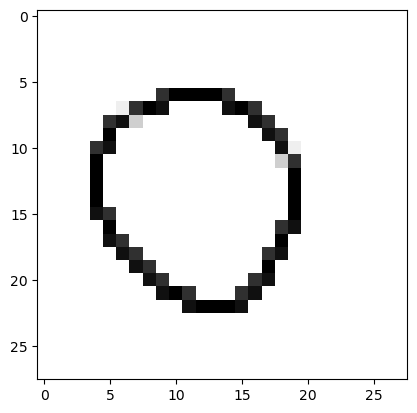

In [8]:
#To read the image 
bgrimg = cv2.imread(str(Zero_dir+'/0-2.png'))

plt.imshow(bgrimg)

#To get rid of the x-ticks and y-ticks on the image axis
#plt.xticks([])
#plt.yticks([])

print('Original Image Shape',bgrimg.shape)

In [17]:
#cv2.imread(str(Zero_dir+'/IMG_0953.png'))

# STEP 2 : Preparing & inspection

In [10]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [11]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,D:/DATA_Science/DATASET/Thainumber\Zero\zero3.png,Zero
1,D:/DATA_Science/DATASET/Thainumber\Two\IMG_087...,Two
2,D:/DATA_Science/DATASET/Thainumber\Nine\nine5.png,Nine
3,D:/DATA_Science/DATASET/Thainumber\Three\three...,Three
4,D:/DATA_Science/DATASET/Thainumber\Six\IMG_092...,Six
...,...,...
295,D:/DATA_Science/DATASET/Thainumber\Two\two1.png,Two
296,D:/DATA_Science/DATASET/Thainumber\Four\4-11.png,Four
297,D:/DATA_Science/DATASET/Thainumber\Four\IMG_08...,Four
298,D:/DATA_Science/DATASET/Thainumber\Eight\IMG_0...,Eight


In [12]:
data.shape

(300, 2)

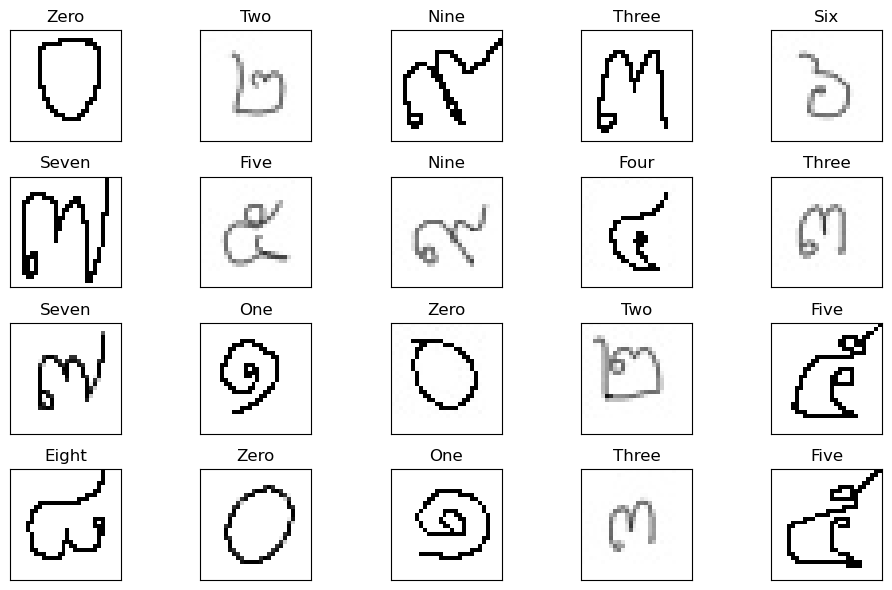

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

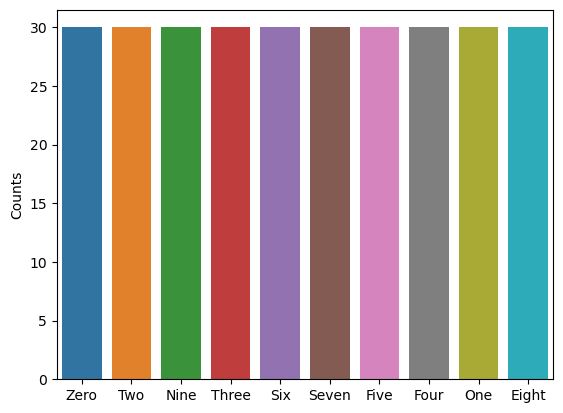

In [14]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

# STEP 3 : Train

In [15]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    read_x.append(img_arr)

Almost_x = np.array(read_x)
x = Almost_x/255       # Devide by 255 is to Normalization

In [16]:
X_train, X_test , y_train, y_test = train_test_split( x, y , test_size=0.3, random_state=42 )

print('Train shape =>',X_train.shape , X_test.shape)
print('Test shape =>',y_train.shape , y_test.shape )

Train shape => (210, 28, 28, 3) (90, 28, 28, 3)
Test shape => (210,) (90,)
